<a href="https://colab.research.google.com/github/Yunbian/DeeplearningPractical/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [29]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)   #tf.keras.utils.get_file是TensorFlow中的一个函数，用于从指定URL下载文件并返回文件的本地路径。
data_dir = pathlib.Path(data_dir).with_suffix('')   #用于改变路径的后缀名。

In [30]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [31]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [32]:
for item in data_dir.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/LICENSE.txt


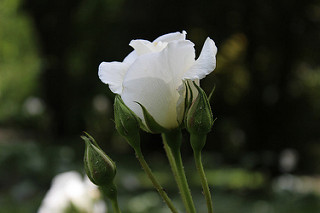

In [33]:
roses = list(data_dir.glob('roses/*'))   #用于匹配文件和目录路径
PIL.Image.open(str(roses[0]))

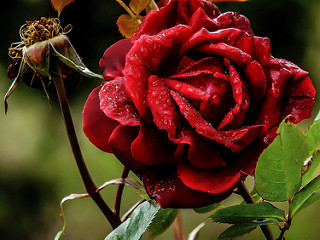

In [34]:
PIL.Image.open(str(roses[1]))

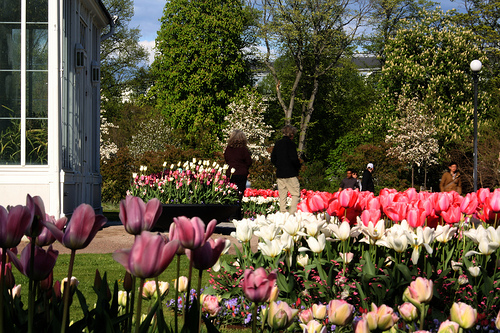

In [35]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

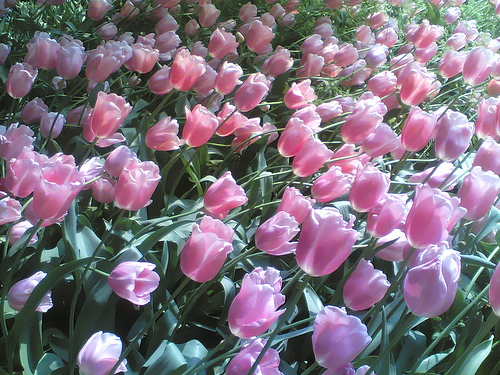

In [36]:
PIL.Image.open(str(tulips[1]))

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(    #目录中加载图像数据集
  data_dir,
  validation_split=0.2,   #验证集划分比例
  subset="training",
  seed=123,
  image_size=(img_height, img_width),   #输入图像调整为指定的尺寸。
  batch_size=batch_size)  #用于指定每个批次中的样本数。

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [39]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [40]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [41]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [42]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

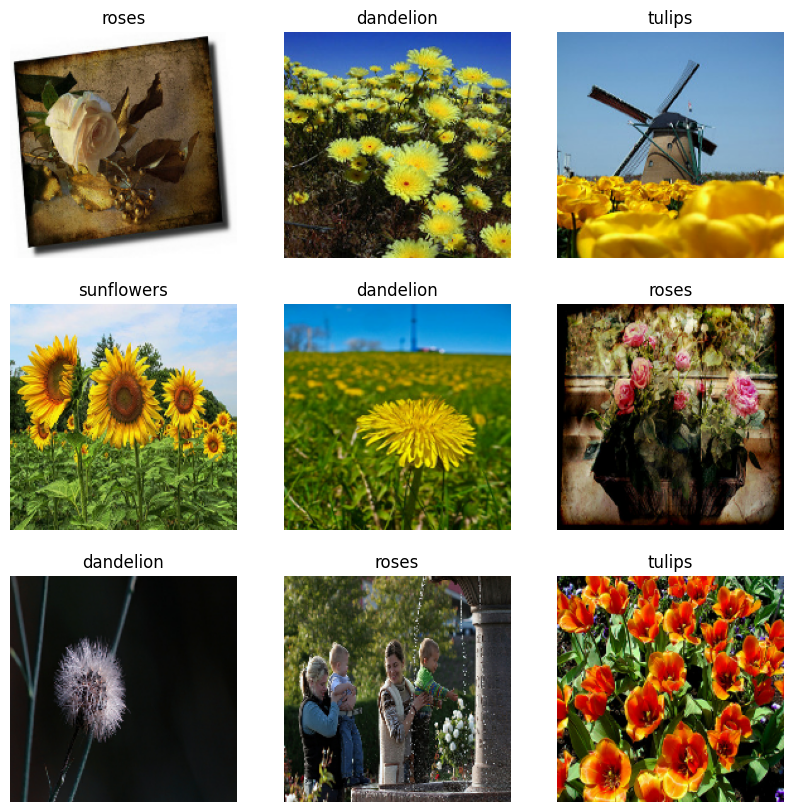

In [43]:
plt.figure(figsize = (10,10))

for images,labels in train_ds.take(1):   #tf.data.Dataset.take()显示训练数据前几张图像
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))   #Dataset.map()方法将数据集中的每个元素传递给map_func函数进行转换，并返回一个新的数据集。可以通过map_func函数对数据进行各种操作
image_batch,labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [47]:


num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [48]:
model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   #from_logits=True 表示模型的输出层直接输出 logits
        metrics=['accuracy']
        )

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

In [50]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 15s 35ms/step - loss: 1.2753 - accuracy: 0.4653 - val_loss: 1.0492 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 0.9853 - accuracy: 0.6107 - val_loss: 0.9478 - val_accuracy: 0.6267
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8303 - accuracy: 0.6846 - val_loss: 0.8971 - val_accuracy: 0.6649
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6534 - accuracy: 0.7582 - val_loss: 0.8915 - val_accuracy: 0.6621
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4472 - accuracy: 0.8392 - val_loss: 0.8959 - val_accuracy: 0.6771
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2918 - accuracy: 0.9036 - val_loss: 1.0649 - val_accuracy: 0.6676
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1597 - accuracy: 0.9475 - val_loss: 1.1807 - val_accuracy: 0.6362
Epoch 8/10
9

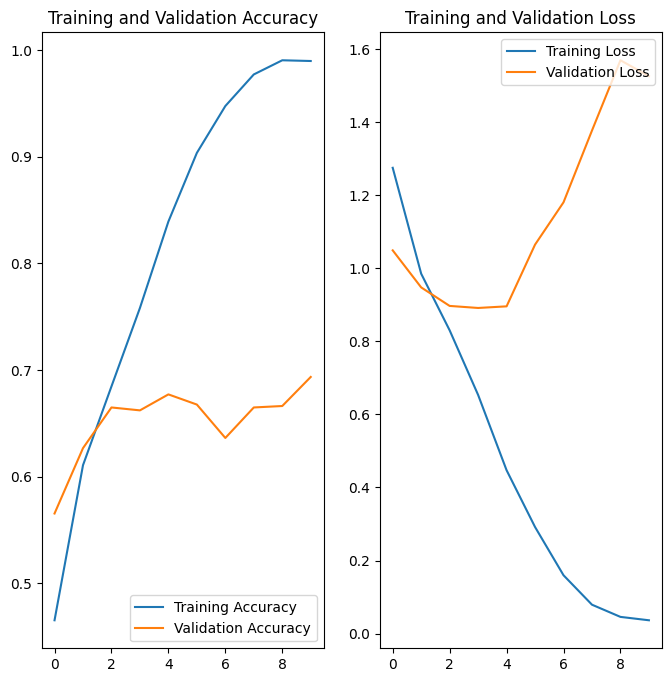

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),  #用于随机翻转输入的图像。一定的概率随机地水平翻转或垂直翻转输入的图像
    layers.RandomRotation(0.1),   #表示图像将在 -10° 到 +10° 范围内进行随机旋转。
    layers.RandomZoom(0.1)   #RandomZoom 层将以给定的因子对输入图像进行随机缩放
])

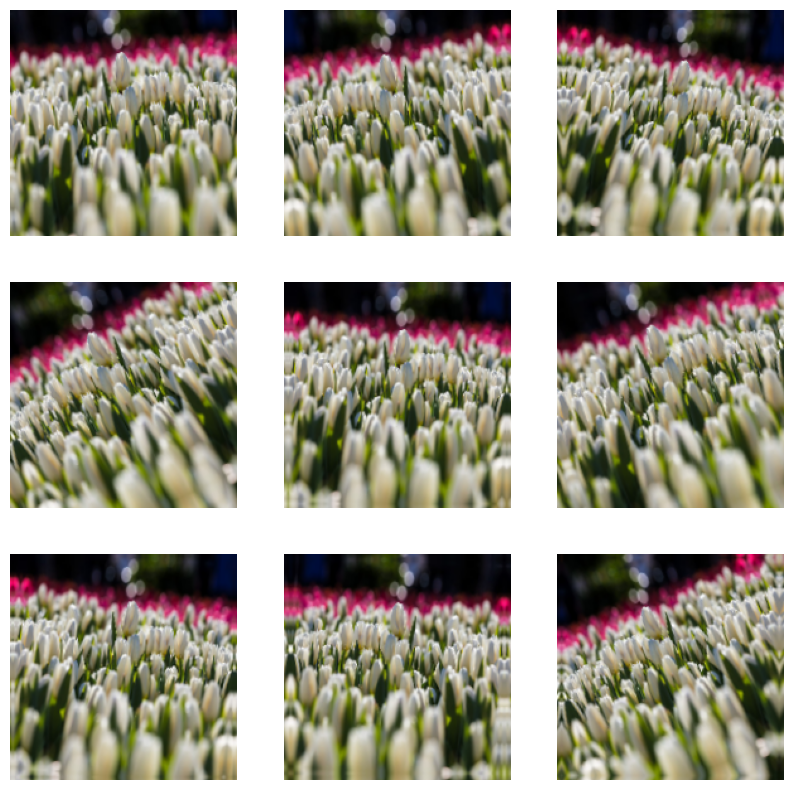

In [54]:
plt.figure(figsize=(10,10))

for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [56]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [59]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 33ms/step - loss: 1.3641 - accuracy: 0.3968 - val_loss: 1.1459 - val_accuracy: 0.5381
Epoch 2/15
92/92 [==============================] - 3s 27ms/step - loss: 1.0804 - accuracy: 0.5552 - val_loss: 1.0736 - val_accuracy: 0.5817
Epoch 3/15
92/92 [==============================] - 3s 28ms/step - loss: 0.9472 - accuracy: 0.6213 - val_loss: 1.0110 - val_accuracy: 0.6458
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8666 - accuracy: 0.6577 - val_loss: 0.8339 - val_accuracy: 0.6608
Epoch 5/15
92/92 [==============================] - 3s 28ms/step - loss: 0.8271 - accuracy: 0.6740 - val_loss: 0.7930 - val_accuracy: 0.6975
Epoch 6/15
92/92 [==============================] - 3s 28ms/step - loss: 0.7645 - accuracy: 0.7020 - val_loss: 0.8303 - val_accuracy: 0.6921
Epoch 7/15
92/92 [==============================] - 3s 28ms/step - loss: 0.7229 - accuracy: 0.7200 - val_loss: 0.7692 - val_accuracy: 0.7016
Epoch 8/15
92

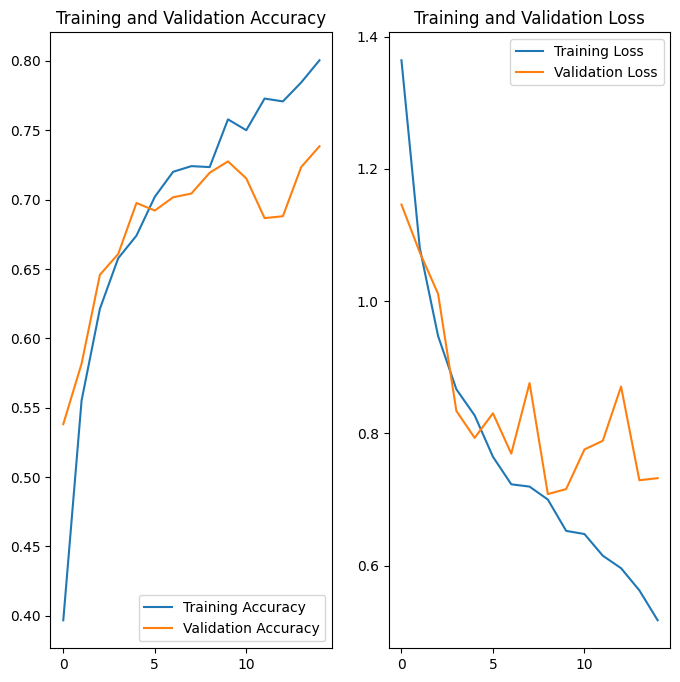

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 215ms/step
This image most likely belongs to sunflowers with a 99.40 percent confidence.
